In [1384]:
# The name of the csv file that you want to read. It should be in the same file level of this code
FORM_NAME = "form3.csv"

'''
Column Form Titles - make sure these match the questions on the form.
'''
NAME_COLUMN = "Name"
PICKUP_COLUMN = "Where would you like to be picked up?"
SERVICE_TYPE_COLUMN = "Which service are you attending?"
AFTER_SERVICE_PLANS_COLUMN = "Preferred after church plans?"
IS_DRIVER_COLUMN = "Are you a driver?"
OC_ADDRESS = "Additional Info" #This is either "Additional Info" or "Off Campus Address" depending on the form question

'''
For the "Where would you like to be pickedup question", the choices for the question should be in here.
There should be a constant and an entry in the dictionary below (should be in both).
'''
NORTH_STOP_NAME = "North (Brown, Duncan, Jones, Martel, McMurtry)"
SOUTH_STOP_NAME = "South (Baker, Hanszen, Lovett, Sid Richardson, Wiess, Will Rice)"
LIFETOWER_STOP_NAME = "Life tower"

location_to_address = {
    NORTH_STOP_NAME: "1601 Rice Boulevard, Houston, TX 77005",
    SOUTH_STOP_NAME: "6320 Main St, Houston, TX 77005",
    LIFETOWER_STOP_NAME: "6919 Main St, Houston, TX 77030",
}

In [1385]:
# Default number of passengers the driver's car can hold.
PASSENGER_LIMIT = 4

'''
This is where you specify the maximum amount of seats a driver will have for a week instead of the default 4.
'''
AMOUNT_SEATS_CHANGE = {
    "Matthew Ahn": 2,
}

'''
Assign drivers who need certain riders as passengers
'''
driver_required_riders_to = {
    # "Jonathan Mak": {"Grace Kwon", "Seojin Kwon"},
    # "AZ Ellis": {"Pedro Flores-Teran"}
}

'''
Assign riders who should ride together
'''
rider_groups_to = [
    {"Khang Le", "seojin Kwon"}
]


'''Back from church'''

'''
Assign drivers who need certain riders as passengers
'''
driver_required_riders_back = {
    # "Jonathan Mak": {"Grace Kwon", "Seojin Kwon"},
    # "AZ Ellis": {"Pedro Flores-Teran"}
}

'''
# Assign riders who should ride together
'''
rider_groups_back = [
    # {"Khang Le", "Aaron duong"}
]

In [1386]:
# Change the hex colors for the Excel here. Make sure it's 8 characters 
# (Add F's in the front if the hex is elss than 8 charactesr)
location_colors = {
    "North": "FFd9ead3",     # light green 3
    "South": "FF93CCEA",     # Light Cornflower Blue 3 
    "Off": "FFFFFFED",       # light yellow
    "Life": "fff4cccc",      # green
    "Back home 💙": "FFD9D2E9",      # light purple
    "RJM": "FFEAD1DC",       # light pink
    "Lunch 💛": "FFFCE5CD",     # light orange
    "Flexible 💚": "FFCFE2F3",        # light blue
    "Refreshments": "FFB6D7A8",
    "NLK 🧡": "FFD9D9D9",
}

------------------------------------

**THE BOTTOM IS CODE THAT SHOULD NOT BE TOUCHED. The parameters above are stuff you can stuff without breaking.**

------------------------------------

In [1387]:
import pandas as pd
from collections import defaultdict
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import random
import time
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.utils import get_column_letter



In [1388]:
df = pd.read_csv(FORM_NAME)

In [1389]:
class Driver:
    def __init__(self, name, amount_seats, pickup_location, service_type, plans):
        self.name = name
        self.amount_seats = amount_seats
        self.pickup_location = pickup_location
        self.service_type = service_type
        self.plans = plans
        self.long_lat_pair = ()

    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, Rider) and self.name == other.name

class Rider:
    def __init__(self, name, pickup_location, service_type, plans):
        self.name = name
        self.pickup_location = pickup_location
        self.service_type = service_type
        self.plans = plans
        self.long_lat_pair = ()

    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, Rider) and self.name == other.name

In [1390]:
coords_to_dist = dict()

def dist(coord1, coord2):
    if (coord1, coord2) in coords_to_dist or (coord2, coord1) in coords_to_dist:
        return coords_to_dist[(coord1, coord2)]
    
    miles_distance = geodesic(coord1, coord2).miles

    coords_to_dist[(coord1, coord2)] = miles_distance
    coords_to_dist[(coord2, coord1)] = miles_distance

    return miles_distance

In [1391]:
def assign_riders_by_furthest_first(drivers, riders, destination):
    rider_dist_to_dest = {r.name: dist(r.long_lat_pair, destination) for r in riders}
    shuffled_riders = list(riders)
    random.shuffle(shuffled_riders)
    sorted_riders = sorted(shuffled_riders, key=lambda r: rider_dist_to_dest[r.name], reverse=True)

    assignments = defaultdict(list)
    driver_last_location = {d: d.long_lat_pair for d in drivers}
    unassigned_riders = set()

    for rider in sorted_riders:
        best_driver = None
        min_marginal_cost = float('inf')

        for driver in drivers:
            if driver.amount_seats <= 0:
                continue
            if driver.service_type != rider.service_type:
                continue

            detour = (
                dist(driver_last_location[driver], rider.long_lat_pair)
                + dist(rider.long_lat_pair, destination)
                - dist(driver_last_location[driver], destination)
            )

            if detour < min_marginal_cost:
                best_driver = driver
                min_marginal_cost = detour

        if best_driver:
            assignments[best_driver].append(rider)
            best_driver.amount_seats -= 1
            driver_last_location[best_driver] = rider.long_lat_pair
        else:
            unassigned_riders.add(rider)

    return assignments, unassigned_riders

def assign_from_church(drivers, riders, church_location):
    shuffled_riders = list(riders)
    random.shuffle(shuffled_riders)
    sorted_riders = sorted(shuffled_riders, key=lambda r: dist(r.long_lat_pair, church_location), reverse=True)

    assignments = defaultdict(list)
    driver_last_location = {d: church_location for d in drivers}
    unassigned_riders = set()

    for rider in sorted_riders:
        best_driver = None
        min_marginal_cost = float('inf')

        for driver in drivers:
            if driver.amount_seats <= 0:
                continue
            if driver.plans != rider.plans:
                continue

            detour = (
                dist(driver_last_location[driver], rider.long_lat_pair)
                + dist(rider.long_lat_pair, driver.long_lat_pair)
                - dist(driver_last_location[driver], driver.long_lat_pair)
            )

            if detour < min_marginal_cost:
                best_driver = driver
                min_marginal_cost = detour

        if best_driver:
            assignments[best_driver].append(rider)
            best_driver.amount_seats -= 1
            driver_last_location[best_driver] = rider.long_lat_pair
        else:
            unassigned_riders.add(rider)

    return assignments, unassigned_riders

In [1392]:
def align_flexible_plans(drivers, riders):
    drivers_by_plan = defaultdict(list)
    for d in drivers:
        if "Flexible" not in d.plans:
            drivers_by_plan[d.plans].append(d)

    # Try to assign flexible riders to existing "Back home" or "Lunch" groups
    for rider in riders:
        if "Flexible" not in rider.plans:
            continue

        for plan in ["Back home 💙", "Lunch 💛"]:
            available_driver = next((d for d in drivers_by_plan[plan] if d.amount_seats > 0), None)
            if available_driver:
                rider.plans = plan
                break  # rider is no longer flexible

    # Now process flexible drivers
    for driver in drivers:
        if "Flexible" not in driver.plans:
            continue

        for plan in ["Back home 💙", "Lunch 💛"]:
            potential_riders = [r for r in riders if r.plans == plan]
            if len(potential_riders) >= 1:
                driver.plans = plan
                drivers_by_plan[plan].append(driver)
                break  # driver is no longer flexible

In [1393]:
def assign_whitelisted_groups(drivers, riders, driver_required_riders, rider_groups):
    assignments = defaultdict(list)
    unassigned_riders = set(riders)

    # Normalize names to lowercase for case-insensitive matching
    name_to_driver = {d.name.lower(): d for d in drivers}
    name_to_rider = {r.name.lower(): r for r in riders}
    remaining_drivers = set(drivers)

    # Step 1: Assign rider-to-rider whitelist groups
    for group in rider_groups:
        # Convert names to lowercase before lookup
        group_objs = [name_to_rider[name.lower()] for name in group if name.lower() in name_to_rider]

        if len(group_objs) < 2:
            continue  # Discard group if fewer than 2 valid riders

        if not all(r in unassigned_riders for r in group_objs):
            continue  # Skip if someone already assigned

        for driver in list(remaining_drivers):
            if driver.amount_seats >= len(group_objs):
                assignments[driver].extend(group_objs)
                for r in group_objs:
                    unassigned_riders.discard(r)
                driver.amount_seats -= len(group_objs)
                if driver.amount_seats == 0:
                    remaining_drivers.discard(driver)
                break

    # Step 2: Assign driver → rider whitelist
    for driver_name, required_names in driver_required_riders.items():
        driver = name_to_driver.get(driver_name.lower())
        if not driver:
            continue

        group_objs = [name_to_rider[name.lower()] for name in required_names if name.lower() in name_to_rider]

        if not group_objs:
            continue  # Skip if no valid riders

        if not all(r in unassigned_riders for r in group_objs):
            continue  # Skip if someone already assigned

        if driver.amount_seats >= len(group_objs):
            assignments[driver].extend(group_objs)
            for r in group_objs:
                unassigned_riders.discard(r)
            driver.amount_seats -= len(group_objs)
            if driver.amount_seats == 0:
                remaining_drivers.discard(driver)

    return assignments, list(remaining_drivers), unassigned_riders

In [1394]:
# Initialize the geocoder
geolocator = Nominatim(user_agent="ride_assignment_NLF")

# Cache for distance: address → distance
address_coords = {}

def geocode_address(address):
    print("GEOCODE_ADDRESS", "address:", address)
    if address in address_coords:
        return address_coords[address]
    try:
        # Avoid appending "Texas" if it's already in the address
        if "texas" not in address.lower():
            full_address = f"{address}, Texas, USA"
        else:
            full_address = f"{address}, USA"

        location = geolocator.geocode(full_address, country_codes="us", timeout=5)
        print("Location returned by API for", full_address, "is", location, "with coord", (location.latitude, location.longitude))

        if location:
            coord = (location.latitude, location.longitude)
            address_coords[address] = coord
            time.sleep(.01)
            return coord
            
    except Exception as e:
        print(f"Geocoding failed for '{address}': {e}")
    return None


In [1395]:
people_list = df[NAME_COLUMN]
locations_list = df[PICKUP_COLUMN]
service_list = df[SERVICE_TYPE_COLUMN]
is_driver_list = df[IS_DRIVER_COLUMN]
plans_list = df[AFTER_SERVICE_PLANS_COLUMN]
oc_address_list = df[OC_ADDRESS]

drivers = set()
riders = set()

for i in range(len(people_list)):
    val = is_driver_list[i]

    if (pd.isna(people_list[i]) or pd.isna(locations_list[i]) or pd.isna(service_list[i]) or pd.isna(plans_list[i])):
        continue
    if pd.isna(val):
        riders.add(Rider(people_list[i], locations_list[i], service_list[i], plans_list[i]))
    else:
        drivers.add(Driver(people_list[i], PASSENGER_LIMIT, locations_list[i], service_list[i], plans_list[i]))

print("List of all drivers:\n")
for d in drivers:
    print(d.name, d.pickup_location)

print(oc_address_list)

# Change the amount of seats a driver would have from the dictionary above.
for d in drivers:
    if d.name in AMOUNT_SEATS_CHANGE:
        print("----", d.name)
        d.amount_seats = AMOUNT_SEATS_CHANGE[d.name]

# print("\nList of all riders:\n")
# for r in riders:
#     print(r.name, r.pickup_location)

List of all drivers:

Josh Paik Off Campus (indicate location in the "Additional Info" section)
Lia Kim Off Campus (indicate location in the "Additional Info" section)
Brian Seo South (Baker, Hanszen, Lovett, Sid Richardson, Wiess, Will Rice)
Matthew Ahn Life tower
Clay Murphy Life tower
Jacob Deadlifts Off Campus (indicate location in the "Additional Info" section)
Jonathan Mak North (Brown, Duncan, Jones, Martel, McMurtry)
Jocelyn Lee Off Campus (indicate location in the "Additional Info" section)
david kim Off Campus (indicate location in the "Additional Info" section)
Ellie Jung Life tower
Oriana Tang Off Campus (indicate location in the "Additional Info" section)
Olivia Chang Life tower
0     2600 bellefontaine st
1                       NaN
2         2022 mcclendon st
3                       NaN
4      2600 Gramercy Street
5           3333 cummins st
6                       NaN
7            1965 Dryden Rd
8             7550 Kirby Dr
9                       NaN
10                 

In [1396]:
drivers = set()
riders = set()
address_to_coord = dict()

oc_people_w_invalid_address = set()

for i in range(len(df)):
    name = df[NAME_COLUMN][i]
    pickup_location = df[PICKUP_COLUMN][i]
    service_type = df[SERVICE_TYPE_COLUMN][i]
    plans = df[AFTER_SERVICE_PLANS_COLUMN ][i]
    is_driver_val = df[IS_DRIVER_COLUMN][i]
    oc_address = df[OC_ADDRESS][i]

    if pd.isna(name): # There's no response for the name
        continue

    if pickup_location not in location_to_address and pd.isna(oc_address) and not pd.isna(name):
        print(f"\n{name} has an empty address cell on the form. They have a pickup location of off campus but did not specify the address in the correct question\n")
        rider = Rider(name, pickup_location, service_type, plans)
        oc_people_w_invalid_address.add(rider)
        continue
    
    # Get address based on pickup location
    if pickup_location in location_to_address:
        address = location_to_address[pickup_location]
    else:
        address = oc_address

    # Get or fetch long-lat coordinate
    if address in address_to_coord:
        coord = address_to_coord[address]
    else:
        print("sending geocode address for:", name, address)
        coord = geocode_address(address)
        address_to_coord[address] = coord
        address_to_coord[address] = coord

    if pd.isna(is_driver_val) or str(is_driver_val).strip() == "":
        rider = Rider(name, pickup_location, service_type, plans)
        rider.long_lat_pair = coord
        riders.add(rider)
    else:
        driver = Driver(name, PASSENGER_LIMIT, pickup_location, service_type, plans)
        driver.long_lat_pair = coord
        drivers.add(driver)

print(f"\nList of people with invalid addresses: {[rider.name for rider in oc_people_w_invalid_address]}")
print(address_to_coord)

sending geocode address for: Rebecca Lu 2600 bellefontaine st
GEOCODE_ADDRESS address: 2600 bellefontaine st
Location returned by API for 2600 bellefontaine st, Texas, USA is 2600, Bellefontaine Street, Braeswood, Houston, Harris County, Texas, 77025, United States with coord (29.703301, -95.418409)
sending geocode address for: Derek Liang  6320 Main St, Houston, TX 77005
GEOCODE_ADDRESS address: 6320 Main St, Houston, TX 77005
Location returned by API for 6320 Main St, Houston, TX 77005, Texas, USA is Baker College, 6320, Main Street, University Place, Houston, Harris County, Texas, 77005, United States with coord (29.7171081, -95.3993378)
sending geocode address for: claudia lin 2022 mcclendon st
GEOCODE_ADDRESS address: 2022 mcclendon st
Location returned by API for 2022 mcclendon st, Texas, USA is 2022, McClendon Street, Southgate, University Place, Houston, Harris County, Texas, 77030, United States with coord (29.708786, -95.4059251)
sending geocode address for: Khang Le 2600 Gra

In [1397]:
def merge_assignments(assignments_main, whitelist_assignments):
    for d_whitelist, riders_whitelist in whitelist_assignments.items():
        # Find matching driver in main assignments
        for d_main in assignments_main:
            if d_main.name.lower() == d_whitelist.name.lower():
                assignments_main[d_main].extend(riders_whitelist)
                d_main.amount_seats -= len(riders_whitelist)
                break
        else:
            # Not yet in main assignments
            assignments_main[d_whitelist] = list(riders_whitelist)
            d_whitelist.amount_seats -= len(riders_whitelist)

In [1398]:
import copy

DESTINATION = (29.892500, -95.525675)

# ---------------- TO CHURCH ---------------- #
drivers_to = [copy.deepcopy(d) for d in drivers]
riders_to = [copy.deepcopy(r) for r in riders]

# Step 1: Apply whitelist rules (ignores plans/service match)
whitelist_assignments_to, remaining_drivers_to, remaining_riders_to = assign_whitelisted_groups(
    drivers_to, riders_to, driver_required_riders_to, rider_groups_to
)

# Step 2: Assign remaining using marginal cost
assignments_to, unassigned_riders_to = assign_riders_by_furthest_first(
    remaining_drivers_to, remaining_riders_to, destination=DESTINATION
)

# Step 3: Merge
merge_assignments(assignments_to, whitelist_assignments_to)


# ---------------- FROM CHURCH ---------------- #
drivers_back = [copy.deepcopy(d) for d in drivers]
riders_back = [copy.deepcopy(r) for r in riders]

# Step 0: Align flexible drivers and riders based on demand
align_flexible_plans(drivers_back, riders_back)

# Step 1: Apply whitelist rules (ignores plan match)
whitelist_assignments_back, remaining_drivers_back, remaining_riders_back = assign_whitelisted_groups(
    drivers_back, riders_back, driver_required_riders_back, rider_groups_back
)

# Step 2: Assign remaining using detour-based marginal cost
assignments_back, unassigned_riders_back = assign_from_church(
    remaining_drivers_back, remaining_riders_back, church_location=DESTINATION
)

# Step 3: Merge
merge_assignments(assignments_back, whitelist_assignments_back)


# ---------------- Debugging / Output ---------------- #
def print_assignment(assignments):  # driver → list of riders
    for driver, rider_list in assignments.items():
        print(f"\nDriver: {driver.name} ({driver.pickup_location})")
        for rider in rider_list:
            print(f"  - {rider.name} ({rider.pickup_location})")

print("Assignments TO Church:")
print_assignment(assignments_to)

print("\nAssignments FROM Church:")
print_assignment(assignments_back)

Assignments TO Church:

Driver: Matthew Ahn (Life tower)
  - Sehyun Jung (Life tower)
  - Nathanael Wang (Life tower)
  - chloe lim (Life tower)
  - Aaron Long (Life tower)

Driver: Clay Murphy (Life tower)
  - Christina Ko (Life tower)
  - JJ Lee (Life tower)
  - Michael Dong  (Life tower)
  - Phillip Seo (Life tower)

Driver: Ellie Jung (Life tower)
  - Grace Park (Life tower)
  - Faith Chen (Off Campus (indicate location in the "Additional Info" section))
  - claudia lin (Off Campus (indicate location in the "Additional Info" section))
  - Jiwang Lee (South (Baker, Hanszen, Lovett, Sid Richardson, Wiess, Will Rice))

Driver: Jocelyn Lee (Off Campus (indicate location in the "Additional Info" section))
  - Rebecca Lu (Off Campus (indicate location in the "Additional Info" section))

Driver: Josh Paik (Off Campus (indicate location in the "Additional Info" section))
  - Jane Yoo (Off Campus (indicate location in the "Additional Info" section))
  - Austin Lee (Off Campus (indicate loca

In [1399]:
location_colors = {
    "North": "FFd9ead3",     # light green 3
    "South": "FF93CCEA",     # Light Cornflower Blue 3 
    "Off": "FFFFFFED",       # light yellow
    "Life": "fff4cccc",      # green
    "Back home 💙": "FFD9D2E9",      # light purple
    "RJM": "FFEAD1DC",       # light pink
    "Lunch 💛": "FFFCE5CD",     # light orange
    "Flexible 💚": "FFCFE2F3",        # light blue
    "Refreshments": "FFB6D7A8",
    "NLK 🧡": "FFD9D9D9",
}

In [1400]:
def export_assignments_to_excel(rides_to, unassigned_riders_to, rides_from, unassigned_riders_from, output_filename="api_allocate.xlsx"):
    wb = Workbook()
    ws = wb.active
    ws.title = "Ride Assignments"

    def place_assignments(assignments, unassigned_riders, start_col, key_col, sort_key_driver, sort_key_rider,
                          driver_color_key, rider_color_key, label_plan=False, include_rider_keys_in_legend=True):
        col = start_col
        row = 2
        curr_car_count = 1
        max_passengers = 0
        local_used_cols = set()
        used_keys = set()

        sorted_assignments = sorted(assignments.items(), key=lambda item: sort_key_driver(item[0]))

        for driver, riders in sorted_assignments:
            driver_text = f"Driver: {driver.name}"
            driver_cell = ws.cell(row=row, column=col, value=driver_text)

            driver_key = driver_color_key(driver)
            used_keys.add(driver_key)
            fill_color = location_colors.get(driver_key, "FFFFFF")
            driver_cell.fill = PatternFill(start_color=fill_color, end_color=fill_color, fill_type="solid")
            driver_cell.alignment = Alignment(horizontal="center")
            driver_cell.font = Font(bold=True, underline="single")
            local_used_cols.add(col)

            max_passengers = max(max_passengers, len(riders))

            sorted_riders = sorted(riders, key=sort_key_rider)
            for i, rider in enumerate(sorted_riders):
                rider_text = f"{rider.name}"
                rider_cell = ws.cell(row=row + 1 + i, column=col, value=rider_text)
                rider_key = rider_color_key(rider)
                if include_rider_keys_in_legend:
                    used_keys.add(rider_key)
                fill_color = location_colors.get(rider_key, "FFFFFF")
                rider_cell.fill = PatternFill(start_color=fill_color, end_color=fill_color, fill_type="solid")
                local_used_cols.add(col)

            if curr_car_count % 5 == 0:
                col = start_col
                row += min(8, max_passengers + 3)
            else:
                col += 1
            curr_car_count += 1

        if unassigned_riders or oc_people_w_invalid_address:
            col += 1
            driver_cell = ws.cell(row=row, column=col, value="UNASSIGNED RIDERS")
            driver_cell.fill = PatternFill(start_color="FFCCCCCC", end_color="FFCCCCCC", fill_type="solid")
            driver_cell.alignment = Alignment(horizontal="center")
            driver_cell.font = Font(bold=True, underline="single")
            local_used_cols.add(col)

            sorted_unassigned = sorted(unassigned_riders.union(oc_people_w_invalid_address), key=sort_key_rider)
            for i, rider in enumerate(sorted_unassigned):
                rider_text = f"{rider.name} ({rider.plans})" if label_plan else f"{rider.name}"
                rider_text += f" No valid driver available to assign this driver" if rider in unassigned_riders else f" (invalid off campus address)"
                rider_cell = ws.cell(row=row + 1 + i, column=col, value=rider_text)
                rider_key = rider_color_key(rider)
                if include_rider_keys_in_legend:
                    used_keys.add(rider_key)
                fill_color = location_colors.get(rider_key, "FFFFFF")
                rider_cell.fill = PatternFill(start_color=fill_color, end_color=fill_color, fill_type="solid")
                local_used_cols.add(col)

        # Create key
        key_row = 2
        for key in sorted(used_keys):
            key_cell = ws.cell(row=key_row, column=key_col, value=key)
            fill_color = location_colors.get(key, "FFFFFF")
            key_cell.fill = PatternFill(start_color=fill_color, end_color=fill_color, fill_type="solid")
            key_row += 1

        return local_used_cols

    # Define sort and color strategies
    sort_by_service_then_pickup = lambda obj: (obj.service_type, obj.pickup_location.split()[0])
    sort_by_pickup = lambda obj: obj.pickup_location.split()[0]
    sort_by_plans = lambda obj: obj.plans
    color_by_pickup = lambda obj: obj.pickup_location.split()[0]
    color_by_plans = lambda obj: obj.plans

    # rides_to (left): include rider pickup locations in key
    used_to = place_assignments(
        rides_to,
        unassigned_riders_to,
        start_col=3,
        key_col=2,
        sort_key_driver=sort_by_service_then_pickup,
        sort_key_rider=sort_by_pickup,
        driver_color_key=color_by_pickup,
        rider_color_key=color_by_pickup,
        label_plan=False,
        include_rider_keys_in_legend=True
    )

    # rides_from (right): do NOT include rider pickup in key
    used_from = place_assignments(
        rides_from,
        unassigned_riders_from,
        start_col=11,
        key_col=10,
        sort_key_driver=sort_by_plans,
        sort_key_rider=sort_by_pickup,
        driver_color_key=color_by_plans,
        rider_color_key=color_by_pickup,
        label_plan=True,
        include_rider_keys_in_legend=False
    )

    for col_index in used_from.union(used_to).union({2, 10}):
        col_letter = get_column_letter(col_index)
        max_length = 0
        for row_cells in ws.iter_rows(min_col=col_index, max_col=col_index):
            for cell in row_cells:
                if cell.value:
                    max_length = max(max_length, len(str(cell.value)))
        ws.column_dimensions[col_letter].width = max_length + 1

    wb.save(output_filename)
    print(f"Excel file saved to {output_filename}")

In [1401]:
export_assignments_to_excel(
    rides_to=assignments_to,
    unassigned_riders_to=unassigned_riders_to,
    rides_from=assignments_back,
    unassigned_riders_from=unassigned_riders_back
)

Excel file saved to api_allocate.xlsx


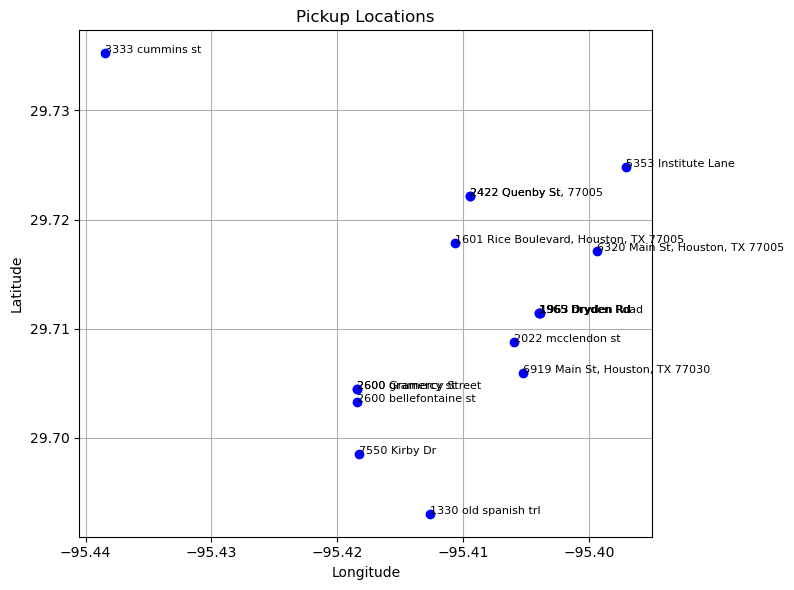

In [1402]:
import matplotlib.pyplot as plt
# address_coords["Church"] =  DESTINATION
lats, lons = zip(*address_coords.values())

plt.figure(figsize=(8, 6))
plt.scatter(lons, lats, c='blue', marker='o')

for label, (lat, lon) in address_coords.items():
    plt.text(lon, lat, label, fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pickup Locations")
plt.grid(True)
plt.tight_layout()
plt.show()